In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

In [3]:
class ReplayMemory():

    def __init__(self,capacity,batch_size):
      self.memory = []
      self.batch_size = batch_size
      self.capacity = capacity
      self.memory_len = 0

    def push(self,item):
      if self.memory_len == self.capacity:
        self.memory.pop(0)
        self.memory.append(item)
      else:
        self.memory.append(item)
        self.memory_len += 1
        
    def sample(self):
      return random.sample(self.memory, self.batch_size)

In [4]:
# my DQN Class
class DQN(nn.Module):

  def __init__(self,in_features,num_actions):
    super().__init__()
    self.fc_1 = nn.Linear(in_features,400)
    self.fc_2 = nn.Linear(400,400)
    self.fc_3 = nn.Linear(400,200)
    self.out = nn.Linear(200,num_actions)

  def forward(self,x):
    x = F.relu(self.fc_1(x))
    x = F.relu(self.fc_2(x))
    x = F.relu(self.fc_3(x))
    out = self.out(x)

    return out

In [5]:
# a function to optimize model
def run_network():
    # if there is not enough experinces in memory just return else sample from it
    if memory.memory_len < batch_size:
        return
    samples = memory.sample()
    batch = [list(s) for s in list(zip(*samples))]

    # compute non final states -> those which their next state is not non
    non_final_mask = []
    for next_state in batch[3]:
      if next_state is None:
        non_final_mask.append(False)
      else:
        non_final_mask.append(True)

    non_final_mask = torch.tensor(tuple(non_final_mask), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([torch.tensor(s) for s in batch[3] if s is not None])
    
    # convert lists of experinces into tensors
    state_batch = torch.cat([torch.tensor(temp) for temp in batch[0]])
    action_batch = torch.cat(batch[1])
    reward_batch = torch.cat(list(batch[2]))

    # compute current state Q-values
    state_q_values = policy_net(state_batch.view(batch_size,-1).float().to(device)).gather(1, action_batch)

    # compute next state Q-values using target net
    next_state_max_values = torch.zeros(batch_size, device=device)
    next_state_max_values[non_final_mask] = target_net(non_final_next_states.view(-1,4).float().to(device)).max(1)[0].detach()

    # Compute MSE LOSS
    loss_function = nn.MSELoss()
    loss = loss_function(state_q_values, (next_state_max_values * discount_factor + reward_batch).unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # i clamped gradient beacause the training is somehow unstable and gradient tends to be nan at some point
    for params in policy_net.parameters():
        params.grad.data.clamp_(-4, 4)
    optimizer.step()


In [6]:
# setting some variables
episodes = 2000
episodes_rewards = []
epsilon = 1
epsilon_decay = 7e-4
min_epsilon = 1e-1
batch_size = 200
discount_factor = 1
target_update = 4
# define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the observation num & action num
n_observation = env.observation_space.shape[0]
n_actions = env.action_space.n
# initialize memory -> capacity : 10000, batch size : 200
memory = ReplayMemory(10000,200)
# define policy net & target net
policy_net = DQN(n_observation, n_actions).to(device)
target_net = DQN(n_observation, n_actions).to(device)
# load policy_net weights to target net
target_net.load_state_dict(policy_net.state_dict())
# set target net to eval so weights dont change
target_net.eval()
# define optimizer
lr = 1e-3
optimizer = optim.Adam(policy_net.parameters(),lr=lr)
steps_done = 0


for episode in range(episodes):
    # Iinitialize the environment
    state = env.reset()
    episode_reward = 0
    # update epsilon
    epsilon = max(min_epsilon,epsilon - epsilon_decay)

    while(True):
        # Select and perform an action
        steps_done += 1
        if np.random.uniform(0,1) > epsilon:
          with torch.no_grad():
            action = policy_net(torch.tensor(state).float().view(1,-1).to(device)).max(1)[1].view(1, 1)
        else:
          action = torch.tensor([[np.random.randint(low=0,high=2,size=1)[0]]], device=device)

        # take a step in environment
        next_state , reward, done, _ = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward], device=device)

        # if done set new state to None
        if not done:
            pass
        else:
            next_state = None

        # store observation into replay-memory
        memory.push([state, action, reward, next_state])
        state = next_state

        # optimize model
        run_network()

        if done:
            break

    print(f'episode {episode + 1} | reward {episode_reward} | epsilon {np.around(epsilon,decimals=4)}')
    episodes_rewards.append(episode_reward)
    # Update the target network, copying all weights and biases in DQN
    if (episode + 1) % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

episode 1 | reward 13.0 | epsilon 0.9993
episode 2 | reward 55.0 | epsilon 0.9986
episode 3 | reward 27.0 | epsilon 0.9979
episode 4 | reward 20.0 | epsilon 0.9972
episode 5 | reward 27.0 | epsilon 0.9965
episode 6 | reward 16.0 | epsilon 0.9958
episode 7 | reward 32.0 | epsilon 0.9951
episode 8 | reward 9.0 | epsilon 0.9944
episode 9 | reward 14.0 | epsilon 0.9937
episode 10 | reward 23.0 | epsilon 0.993
episode 11 | reward 30.0 | epsilon 0.9923
episode 12 | reward 17.0 | epsilon 0.9916
episode 13 | reward 33.0 | epsilon 0.9909
episode 14 | reward 46.0 | epsilon 0.9902
episode 15 | reward 18.0 | epsilon 0.9895
episode 16 | reward 20.0 | epsilon 0.9888
episode 17 | reward 23.0 | epsilon 0.9881
episode 18 | reward 10.0 | epsilon 0.9874
episode 19 | reward 21.0 | epsilon 0.9867
episode 20 | reward 21.0 | epsilon 0.986
episode 21 | reward 45.0 | epsilon 0.9853
episode 22 | reward 30.0 | epsilon 0.9846
episode 23 | reward 12.0 | epsilon 0.9839
episode 24 | reward 27.0 | epsilon 0.9832
epis

Text(0, 0.5, 'reward')

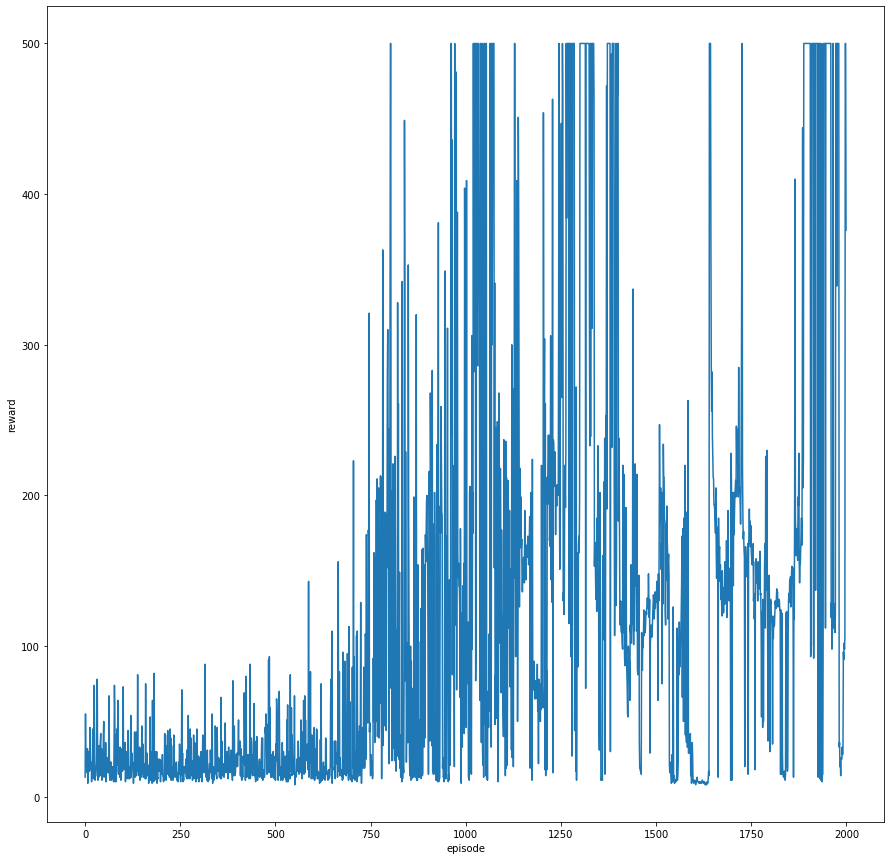

In [7]:
# plotting total reward in each episode
plt.figure(figsize=(15,15))
plt.plot(np.arange(0,episodes),episodes_rewards)
plt.xlabel('episode')
plt.ylabel('reward')

In [8]:
# test network for 100 epidoes i ouputed average reward
episodes_rewards = []
episodes = 100
for episode in range(episodes):
  episode_reward = 0
  state = env.reset()
  done = False

  while(not done):
    with torch.no_grad():
      action = torch.argmax(policy_net(torch.tensor(state).view(1,-1).float().to(device)),dim=1).item()

    next_state, reward, done, info = env.step(action)
    episode_reward += reward
    state = next_state

  episodes_rewards.append(episode_reward)
  print(f'episode {episode + 1} | reward {episode_reward}')

print('######################################################')
print(f'average reward over {episodes} run is {np.mean(episodes_rewards)}')

episode 1 | reward 500.0
episode 2 | reward 276.0
episode 3 | reward 500.0
episode 4 | reward 500.0
episode 5 | reward 288.0
episode 6 | reward 500.0
episode 7 | reward 277.0
episode 8 | reward 500.0
episode 9 | reward 284.0
episode 10 | reward 500.0
episode 11 | reward 500.0
episode 12 | reward 275.0
episode 13 | reward 287.0
episode 14 | reward 500.0
episode 15 | reward 500.0
episode 16 | reward 500.0
episode 17 | reward 500.0
episode 18 | reward 500.0
episode 19 | reward 500.0
episode 20 | reward 337.0
episode 21 | reward 500.0
episode 22 | reward 281.0
episode 23 | reward 268.0
episode 24 | reward 500.0
episode 25 | reward 333.0
episode 26 | reward 284.0
episode 27 | reward 402.0
episode 28 | reward 313.0
episode 29 | reward 500.0
episode 30 | reward 323.0
episode 31 | reward 274.0
episode 32 | reward 500.0
episode 33 | reward 500.0
episode 34 | reward 277.0
episode 35 | reward 331.0
episode 36 | reward 286.0
episode 37 | reward 500.0
episode 38 | reward 254.0
episode 39 | reward 2